In [1]:
#pip install xgboost
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns

In [2]:
### Darts: Time Series Made Easy in Python
from darts import TimeSeries
from darts.utils.statistics import extract_trend_and_seasonality
from darts.utils.utils import ModelMode
from darts.metrics import mape
from darts.utils.statistics import plot_residuals_analysis
from darts.models import XGBModel

import optuna

C:\Users\aryck\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path_weekly = "../../SRAG_time_series/SRAG_TS_weekly.csv"
path_daily = "../../SRAG_time_series/SRAG_TS.csv"

df_weekly  = pd.read_csv(path_weekly, sep=",", encoding="latin-1")
df_daily = pd.read_csv(path_daily, sep=",", encoding="latin-1")

In [4]:
df_weekly["Year_Week"] = pd.to_datetime(df_weekly["Year_Week"])
df_daily["Date"] = pd.to_datetime(df_daily["Date"])
df_weekly = df_weekly.sort_values('Year_Week')

In [5]:
#df_weekly = df_weekly.set_index("Year_Week")
df_weekly.drop(columns=['week'], inplace=True)
df_weekly = df_weekly.iloc[1:]
df_weekly

,Year_Week,Number_Cases
1,2019-01-07,256.0
2,2019-01-14,270.0
3,2019-01-21,273.0
4,2019-01-28,282.0
5,2019-02-04,300.0
...,...,...
313,2024-12-02,4298.0
314,2024-12-09,4284.0
315,2024-12-16,4028.0
316,2024-12-23,4028.0


In [6]:
df_weekly = df_weekly.drop_duplicates(subset='Year_Week', keep='first')

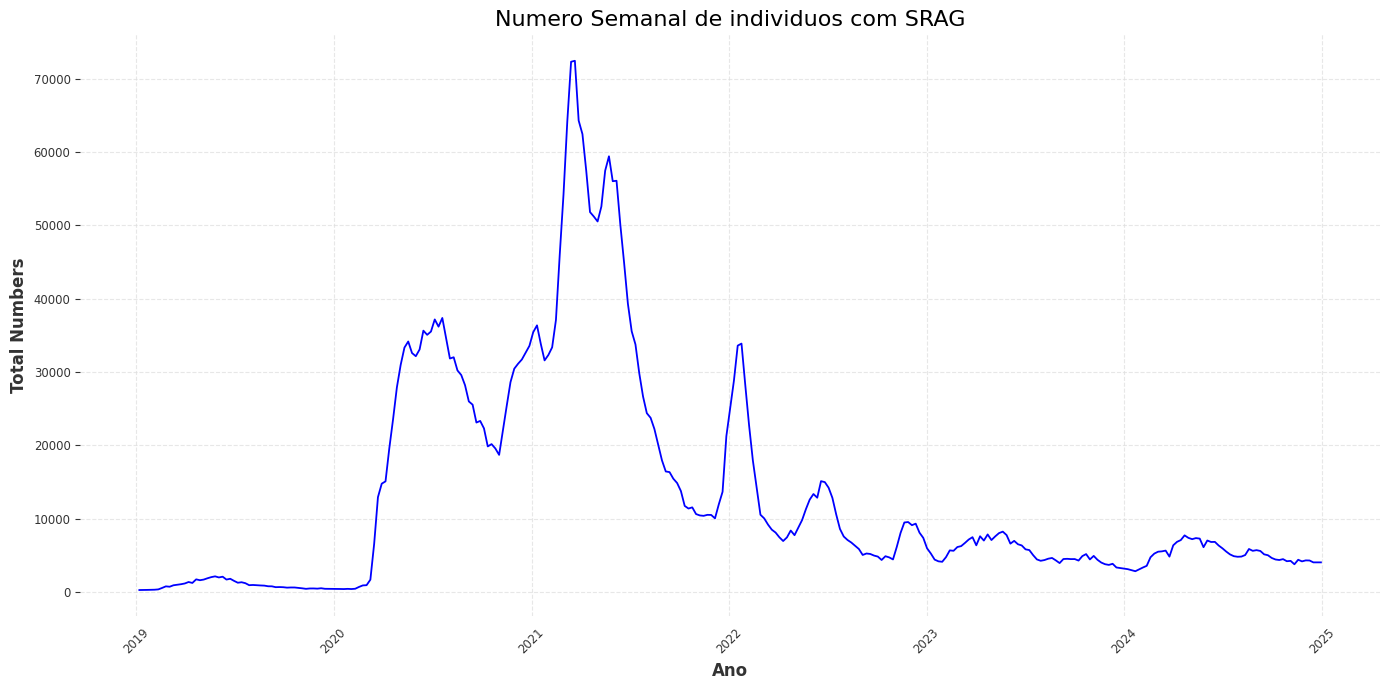

In [7]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_weekly, x='Year_Week', y='Number_Cases', color='b')
#sns.lineplot(data=df_daily, x='Number', y='Number', color='b')


# Customize the plot
plt.title('Numero Semanal de individuos com SRAG', fontsize=16)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Total Numbers', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Transformando em TimeSeries da darts

In [8]:
full_index = pd.date_range(start=df_weekly['Year_Week'].min(),
                           end=df_weekly['Year_Week'].max(),
                           freq='W-MON')

missing = full_index.difference(df_weekly['Year_Week'])
print("Missing weeks:", missing)


Missing weeks: DatetimeIndex([], dtype='datetime64[ns]', freq='W-MON')


In [9]:
non_mondays = df_weekly[~(df_weekly['Year_Week'].dt.weekday == 0)]
print(non_mondays)

    Year_Week  Number_Cases
53 2020-01-01         414.5


In [10]:
df_weekly['Year_Week'] = df_weekly['Year_Week'] - pd.to_timedelta(df_weekly['Year_Week'].dt.weekday, unit='d')

C:\Users\aryck\AppData\Local\Temp\ipykernel_41260\3759238453.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Year_Week'] = df_weekly['Year_Week'] - pd.to_timedelta(df_weekly['Year_Week'].dt.weekday, unit='d')


In [11]:
df_weekly = df_weekly.groupby('Year_Week', as_index=False)['Number_Cases'].sum()

In [12]:
series_weekly = TimeSeries.from_dataframe(
    df_weekly,
    time_col='Year_Week',
    value_cols='Number_Cases',
    fill_missing_dates=True,
    freq='W-MON'
)

<Axes: xlabel='Year_Week'>

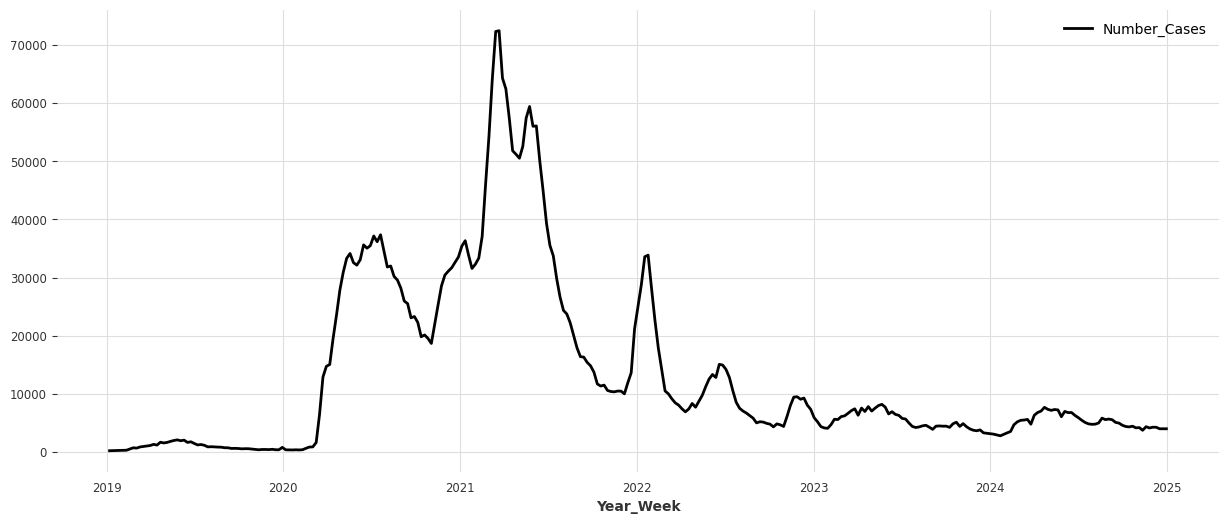

In [13]:
figure = plt.figure(figsize = (15,6))
series_weekly.plot()

In [14]:
import pickle

# Salvando no formato .pkl
with open("series_weekly_SRAG.pkl", "wb") as f:
    pickle.dump(series_weekly, f)

### Train Test Split

In [15]:
def train_test_splits(series, train_proportion_list):
    '''
    Funcao para dividir a serie temporal em treino e teste
    
    Parametros:
    
    *series: serie que sera particionada em treino e validacao.
    *train_proportion_list: Lista que define a proporcao do conjunto
    de treinamento. Ex: series_list = [0.8,0.5] significa primeiro conjunto 
    de treino com 80% dos dados totais e o segundo com 50% dos dados totais.
    '''
    partitions_dict = {'train': [], 'test': []}

    for i, train_proportion in enumerate(train_proportion_list):
        train_size = int(len(series) * train_proportion)
        train, test = series.split_before(train_size)
        partitions_dict['train'].append(train)
        partitions_dict['test'].append(test)

        print(f'Partition {i+1} - Train size: {len(train)}, Test size: {len(test)}, Total size: {len(train)+len(test)}')

    return partitions_dict

In [16]:
train_test_df_weekly = train_test_splits(series_weekly, [0.83])

train_83 = train_test_df_weekly['train'][0]
test_17 = train_test_df_weekly['test'][0]

Partition 1 - Train size: 259, Test size: 54, Total size: 313


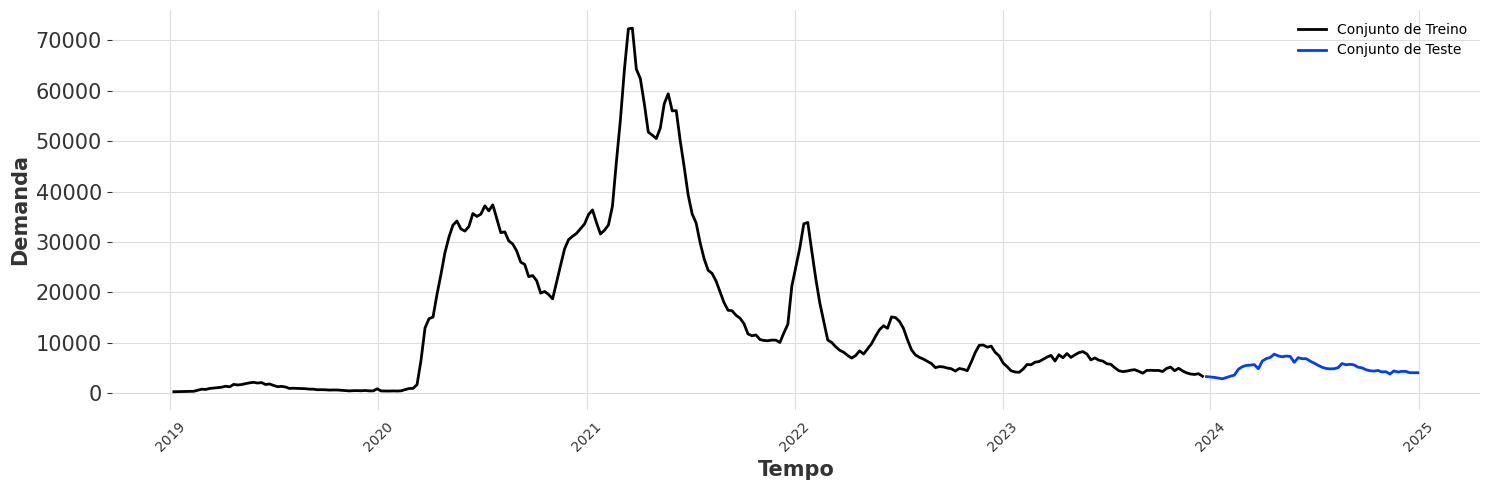

In [17]:
## Plotando
plt.figure(figsize=(15, 5))

train_test_df_weekly['train'][0].plot(label='Conjunto de Treino')

train_test_df_weekly['test'][0].plot(label='Conjunto de Teste')

plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=15)
plt.xlabel('Tempo', fontsize=15)
plt.ylabel('Demanda', fontsize=15)
plt.legend()
plt.tight_layout()
plt.show()

### XGBoost Model

In [26]:
model = XGBModel(
    lags=24,  # use past 12 values as features
    output_chunk_length=5
)

# Fit the model
model.fit(train_83)

# Predict next 24 weeks
prediction = model.predict(n=150)

In [27]:
mape_pred = mape(test_17 ,prediction)
mape_pred

np.float64(51.040368781774134)

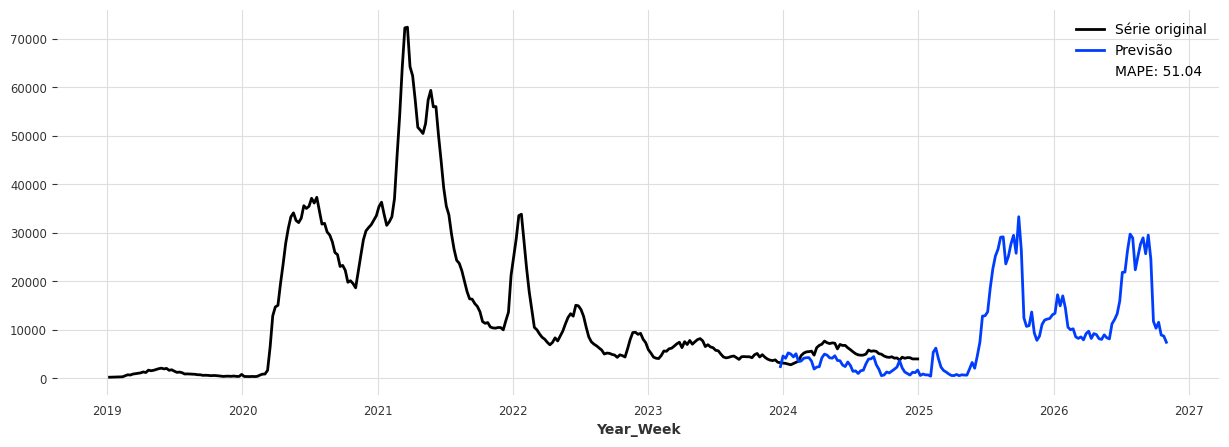

In [28]:
fig = plt.figure(figsize=(15,5))
series_weekly.plot(label='Série original')
prediction.plot(label='Previsão')
plt.plot([],[],' ',label=f'MAPE: {round(mape_pred,2)}')
plt.legend()
plt.show()

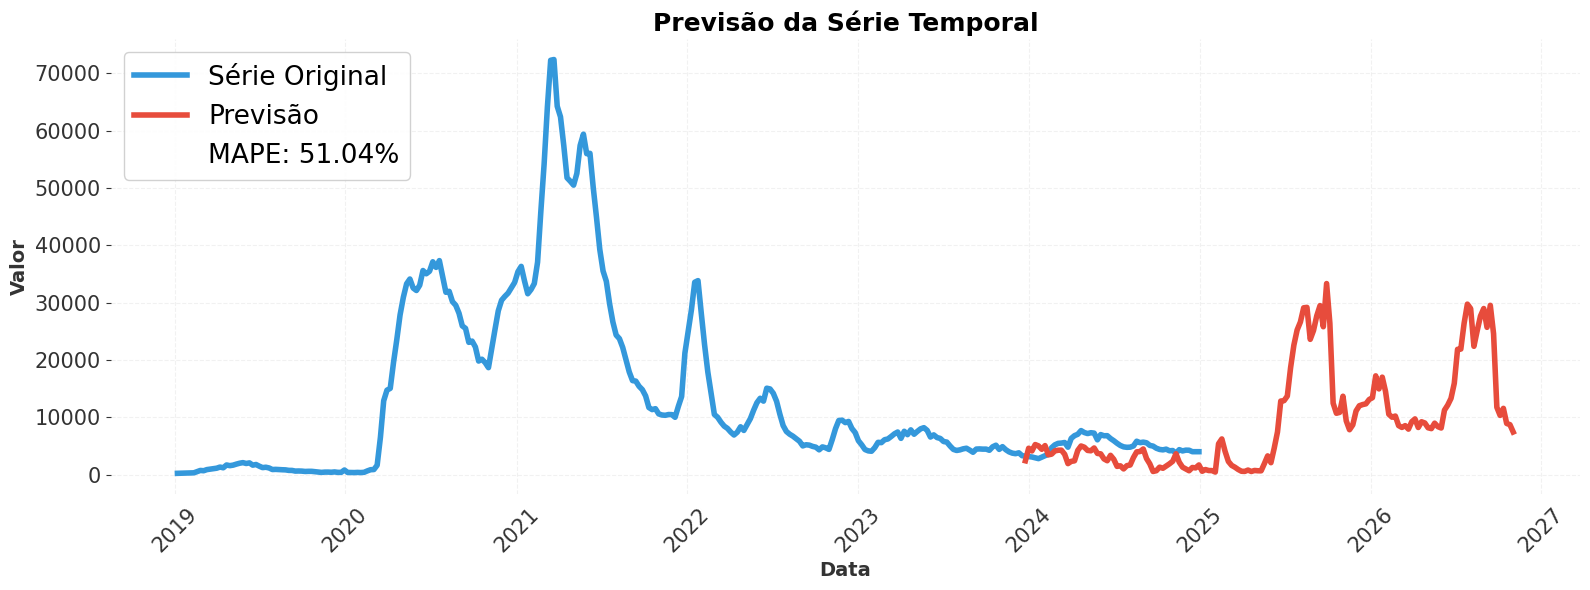

In [32]:


# Criar a figura
fig = plt.figure(figsize=(16, 6))

# Plotar a série original e a previsão
series_weekly.plot(label='Série Original', lw=4, color='#3498db')  # Azul suave
prediction.plot(label='Previsão', lw=4, color='#e74c3c')           # Vermelho forte

# Adicionar o MAPE como "legenda invisível"
plt.plot([], [], ' ', label=f'MAPE: {round(mape_pred, 2)}%')

# Melhorar a legenda
plt.legend(fontsize=19, frameon=True, framealpha=0.9, loc='upper left')

# Título e eixos com tipografia
plt.title('Previsão da Série Temporal', fontsize=18, fontweight='bold')
plt.xlabel('Data', fontsize=14)
plt.ylabel('Valor', fontsize=14)

# Ticks legíveis
plt.xticks(fontsize=15, rotation=45)
plt.yticks(fontsize=15)

# Grid sutil
plt.grid(True, linestyle='--', alpha=0.4)

# Bordas suaves
plt.tight_layout()
plt.show()

### Setup de treinamento com OPTUNA (XGBoost Model)

In [21]:
# Define objective function for Optuna
def objective(trial):
    params = {
        "lags": trial.suggest_int("lags", 1, 36),
        "output_chunk_length": trial.suggest_int("output_chunk_length", 1, 12),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 1),
    }
    
    # Initialize model
    model = XGBModel(
        lags=params["lags"],
        output_chunk_length=params["output_chunk_length"],
        random_state=42,
        **{k: v for k, v in params.items() if k not in ["lags", "output_chunk_length"]}
    )

    # Fit model
    model.fit(
        series=train_83,
        verbose=False
    )
    
    # Evaluate on validation set
    preds = model.predict(
        n=len(test_17),
    )
    
    # Return MAPE (we minimize this)
    return mape(test_17, preds)

In [22]:
# Create study and optimize
study = optuna.create_study(direction="minimize")

# Global variable to store best model
best_model = None

[I 2025-06-02 18:25:46,383] A new study created in memory with name: no-name-61034846-62a5-4365-b201-4ff92d4b65df


In [23]:
# Callback to save best model
def callback(study, trial):
    global best_model
    if study.best_trial.number == trial.number:
        best_params = trial.params
        best_model = XGBModel(
            lags=best_params["lags"],
            output_chunk_length=best_params["output_chunk_length"],
            random_state=42,
            **{k: v for k, v in best_params.items() if k not in ["lags", "output_chunk_length"]}
        )
        best_model.fit(series=train_83)

# Run optimization
study.optimize(objective, n_trials=30, callbacks=[callback], show_progress_bar=True)

Best trial: 0. Best value: 176.482:   3%|█▌                                             | 1/30 [00:00<00:04,  6.45it/s]

[I 2025-06-02 18:25:46,484] Trial 0 finished with value: 176.4822549005215 and parameters: {'lags': 4, 'output_chunk_length': 1, 'n_estimators': 187, 'max_depth': 3, 'learning_rate': 0.00808941129261326, 'subsample': 0.6203036024376152, 'colsample_bytree': 0.8192297581216514, 'min_child_weight': 7, 'gamma': 0.6942258553661198}. Best is trial 0 with value: 176.4822549005215.


Best trial: 0. Best value: 176.482:   3%|█▌                                             | 1/30 [00:00<00:04,  6.45it/s]

[I 2025-06-02 18:25:47,288] Trial 1 finished with value: 149.23252506328265 and parameters: {'lags': 21, 'output_chunk_length': 11, 'n_estimators': 168, 'max_depth': 9, 'learning_rate': 0.0048358429336310856, 'subsample': 0.5501087240872696, 'colsample_bytree': 0.5641138411925926, 'min_child_weight': 9, 'gamma': 0.23230128254839444}. Best is trial 1 with value: 149.23252506328265.


Best trial: 1. Best value: 149.233:   7%|███▏                                           | 2/30 [00:09<00:24,  1.13it/s]

[I 2025-06-02 18:25:55,544] Trial 2 finished with value: 36.03169399300925 and parameters: {'lags': 32, 'output_chunk_length': 8, 'n_estimators': 397, 'max_depth': 10, 'learning_rate': 0.01283323462172742, 'subsample': 0.5195739324368422, 'colsample_bytree': 0.584712655153188, 'min_child_weight': 1, 'gamma': 0.9253333662817264}. Best is trial 2 with value: 36.03169399300925.


Best trial: 2. Best value: 36.0317:  13%|██████▎                                        | 4/30 [00:16<02:00,  4.62s/it]

[I 2025-06-02 18:26:03,047] Trial 3 finished with value: 193.41872935036912 and parameters: {'lags': 2, 'output_chunk_length': 6, 'n_estimators': 385, 'max_depth': 6, 'learning_rate': 0.0016788476265538787, 'subsample': 0.5588853764756596, 'colsample_bytree': 0.6935125007304761, 'min_child_weight': 7, 'gamma': 0.2742280199735164}. Best is trial 2 with value: 36.03169399300925.


Best trial: 2. Best value: 36.0317:  13%|██████▎                                        | 4/30 [00:17<02:00,  4.62s/it]

[I 2025-06-02 18:26:03,610] Trial 4 finished with value: 25.752531213658298 and parameters: {'lags': 36, 'output_chunk_length': 7, 'n_estimators': 288, 'max_depth': 3, 'learning_rate': 0.012879373902919688, 'subsample': 0.6502341381081969, 'colsample_bytree': 0.5805033081859172, 'min_child_weight': 2, 'gamma': 0.16897802547054774}. Best is trial 4 with value: 25.752531213658298.


Best trial: 4. Best value: 25.7525:  17%|███████▊                                       | 5/30 [00:18<01:24,  3.36s/it]

[I 2025-06-02 18:26:05,075] Trial 5 finished with value: 24.073972770908043 and parameters: {'lags': 27, 'output_chunk_length': 4, 'n_estimators': 430, 'max_depth': 6, 'learning_rate': 0.016950761518646884, 'subsample': 0.698792410116979, 'colsample_bytree': 0.7881885299001004, 'min_child_weight': 6, 'gamma': 0.3952164057194332}. Best is trial 5 with value: 24.073972770908043.


Best trial: 5. Best value: 24.074:  23%|███████████▏                                    | 7/30 [00:19<00:46,  2.03s/it]

[I 2025-06-02 18:26:06,370] Trial 6 finished with value: 206.8490295139826 and parameters: {'lags': 2, 'output_chunk_length': 3, 'n_estimators': 289, 'max_depth': 6, 'learning_rate': 0.001487959637157041, 'subsample': 0.5638228391567669, 'colsample_bytree': 0.7855658961496497, 'min_child_weight': 6, 'gamma': 0.8259572072253232}. Best is trial 5 with value: 24.073972770908043.


Best trial: 5. Best value: 24.074:  27%|████████████▊                                   | 8/30 [00:20<00:35,  1.60s/it]

[I 2025-06-02 18:26:07,058] Trial 7 finished with value: 199.14545545221137 and parameters: {'lags': 10, 'output_chunk_length': 4, 'n_estimators': 439, 'max_depth': 8, 'learning_rate': 0.058351965788607574, 'subsample': 0.623746223240361, 'colsample_bytree': 0.747144185631138, 'min_child_weight': 9, 'gamma': 0.39042434253893865}. Best is trial 5 with value: 24.073972770908043.


Best trial: 5. Best value: 24.074:  30%|██████████████▍                                 | 9/30 [00:21<00:27,  1.33s/it]

[I 2025-06-02 18:26:07,788] Trial 8 finished with value: 208.89804573447233 and parameters: {'lags': 8, 'output_chunk_length': 5, 'n_estimators': 136, 'max_depth': 9, 'learning_rate': 0.001268832673911625, 'subsample': 0.5506965019299144, 'colsample_bytree': 0.5539814596850718, 'min_child_weight': 2, 'gamma': 0.37160907821806466}. Best is trial 5 with value: 24.073972770908043.


Best trial: 5. Best value: 24.074:  33%|███████████████▋                               | 10/30 [00:22<00:26,  1.33s/it]

[I 2025-06-02 18:26:09,124] Trial 9 finished with value: 248.6144271864124 and parameters: {'lags': 35, 'output_chunk_length': 4, 'n_estimators': 123, 'max_depth': 6, 'learning_rate': 0.001098516345544052, 'subsample': 0.8068258690370054, 'colsample_bytree': 0.9524881167563057, 'min_child_weight': 8, 'gamma': 0.40337048645352014}. Best is trial 5 with value: 24.073972770908043.


Best trial: 5. Best value: 24.074:  37%|█████████████████▏                             | 11/30 [00:26<00:38,  2.02s/it]

[I 2025-06-02 18:26:12,696] Trial 10 finished with value: 58.05014551557882 and parameters: {'lags': 23, 'output_chunk_length': 10, 'n_estimators': 493, 'max_depth': 4, 'learning_rate': 0.05137420209950613, 'subsample': 0.9730190989919661, 'colsample_bytree': 0.9260224119869376, 'min_child_weight': 4, 'gamma': 0.06797559680518939}. Best is trial 5 with value: 24.073972770908043.


Best trial: 5. Best value: 24.074:  40%|██████████████████▊                            | 12/30 [00:27<00:30,  1.67s/it]

[I 2025-06-02 18:26:13,572] Trial 11 finished with value: 24.230319267207065 and parameters: {'lags': 28, 'output_chunk_length': 8, 'n_estimators': 294, 'max_depth': 4, 'learning_rate': 0.023171304314046477, 'subsample': 0.7463061154564234, 'colsample_bytree': 0.6572295348083249, 'min_child_weight': 4, 'gamma': 0.05550086876167215}. Best is trial 5 with value: 24.073972770908043.


Best trial: 5. Best value: 24.074:  43%|████████████████████▎                          | 13/30 [00:28<00:27,  1.63s/it]

[I 2025-06-02 18:26:15,118] Trial 12 finished with value: 33.63929245571799 and parameters: {'lags': 27, 'output_chunk_length': 9, 'n_estimators': 368, 'max_depth': 5, 'learning_rate': 0.02672121994236688, 'subsample': 0.7542696345459599, 'colsample_bytree': 0.6691362311293301, 'min_child_weight': 4, 'gamma': 0.5917799835967308}. Best is trial 5 with value: 24.073972770908043.


Best trial: 5. Best value: 24.074:  47%|█████████████████████▉                         | 14/30 [00:29<00:21,  1.33s/it]

[I 2025-06-02 18:26:15,757] Trial 13 finished with value: 63.245496583437486 and parameters: {'lags': 28, 'output_chunk_length': 12, 'n_estimators': 56, 'max_depth': 5, 'learning_rate': 0.027323305864917716, 'subsample': 0.863007611693099, 'colsample_bytree': 0.8695097288957515, 'min_child_weight': 4, 'gamma': 0.024709026369534093}. Best is trial 5 with value: 24.073972770908043.


Best trial: 5. Best value: 24.074:  50%|███████████████████████▌                       | 15/30 [00:29<00:15,  1.01s/it]

[I 2025-06-02 18:26:16,014] Trial 14 finished with value: 51.30471929155014 and parameters: {'lags': 14, 'output_chunk_length': 2, 'n_estimators': 231, 'max_depth': 7, 'learning_rate': 0.0979373273109737, 'subsample': 0.7213119255596058, 'colsample_bytree': 0.6828889941053278, 'min_child_weight': 5, 'gamma': 0.5810404667554756}. Best is trial 5 with value: 24.073972770908043.


Best trial: 5. Best value: 24.074:  53%|█████████████████████████                      | 16/30 [00:30<00:12,  1.08it/s]

[I 2025-06-02 18:26:16,757] Trial 15 finished with value: 86.78449432487457 and parameters: {'lags': 17, 'output_chunk_length': 6, 'n_estimators': 338, 'max_depth': 4, 'learning_rate': 0.00390223204368365, 'subsample': 0.7164646362741047, 'colsample_bytree': 0.7306537297121557, 'min_child_weight': 5, 'gamma': 0.13267043993650485}. Best is trial 5 with value: 24.073972770908043.


Best trial: 5. Best value: 24.074:  57%|██████████████████████████▋                    | 17/30 [00:32<00:15,  1.20s/it]

[I 2025-06-02 18:26:18,597] Trial 16 finished with value: 32.717025158510275 and parameters: {'lags': 27, 'output_chunk_length': 8, 'n_estimators': 473, 'max_depth': 5, 'learning_rate': 0.023947376116082282, 'subsample': 0.8662315564346559, 'colsample_bytree': 0.6362023878399317, 'min_child_weight': 3, 'gamma': 0.2618637781124721}. Best is trial 5 with value: 24.073972770908043.


Best trial: 5. Best value: 24.074:  57%|██████████████████████████▋                    | 17/30 [00:33<00:15,  1.20s/it]

[I 2025-06-02 18:26:19,796] Trial 17 finished with value: 23.480561192054623 and parameters: {'lags': 30, 'output_chunk_length': 5, 'n_estimators': 340, 'max_depth': 7, 'learning_rate': 0.016937122404784725, 'subsample': 0.7902714409236762, 'colsample_bytree': 0.8473843692910212, 'min_child_weight': 6, 'gamma': 0.7341317888468494}. Best is trial 17 with value: 23.480561192054623.


Best trial: 17. Best value: 23.4806:  63%|████████████████████████████▌                | 19/30 [00:38<00:22,  2.02s/it]

[I 2025-06-02 18:26:24,790] Trial 18 finished with value: 44.564283322013715 and parameters: {'lags': 23, 'output_chunk_length': 3, 'n_estimators': 421, 'max_depth': 7, 'learning_rate': 0.006186382221466995, 'subsample': 0.9529709941262281, 'colsample_bytree': 0.8656924990318405, 'min_child_weight': 10, 'gamma': 0.7442888646888357}. Best is trial 17 with value: 23.480561192054623.


Best trial: 17. Best value: 23.4806:  67%|██████████████████████████████               | 20/30 [00:39<00:17,  1.77s/it]

[I 2025-06-02 18:26:25,966] Trial 19 finished with value: 172.11972588389028 and parameters: {'lags': 32, 'output_chunk_length': 5, 'n_estimators': 340, 'max_depth': 8, 'learning_rate': 0.0030273364142285, 'subsample': 0.814440188880857, 'colsample_bytree': 0.9834234362675249, 'min_child_weight': 6, 'gamma': 0.9811775040815791}. Best is trial 17 with value: 23.480561192054623.


Best trial: 17. Best value: 23.4806:  67%|██████████████████████████████               | 20/30 [00:40<00:17,  1.77s/it]

[I 2025-06-02 18:26:26,466] Trial 20 finished with value: 20.144920584659438 and parameters: {'lags': 32, 'output_chunk_length': 1, 'n_estimators': 456, 'max_depth': 8, 'learning_rate': 0.01624439919770919, 'subsample': 0.6790797238013695, 'colsample_bytree': 0.8341981492753374, 'min_child_weight': 7, 'gamma': 0.5316956566706923}. Best is trial 20 with value: 20.144920584659438.


Best trial: 20. Best value: 20.1449:  73%|█████████████████████████████████            | 22/30 [00:41<00:10,  1.34s/it]

[I 2025-06-02 18:26:27,838] Trial 21 finished with value: 22.992028841027793 and parameters: {'lags': 33, 'output_chunk_length': 2, 'n_estimators': 447, 'max_depth': 8, 'learning_rate': 0.015382924235316484, 'subsample': 0.6811965565443173, 'colsample_bytree': 0.8344435797047928, 'min_child_weight': 7, 'gamma': 0.5116921799602296}. Best is trial 20 with value: 20.144920584659438.


Best trial: 20. Best value: 20.1449:  73%|█████████████████████████████████            | 22/30 [00:41<00:10,  1.34s/it]

[I 2025-06-02 18:26:28,278] Trial 22 finished with value: 19.146325476375996 and parameters: {'lags': 32, 'output_chunk_length': 1, 'n_estimators': 461, 'max_depth': 8, 'learning_rate': 0.009840841359642449, 'subsample': 0.6834699989545864, 'colsample_bytree': 0.8651527211863093, 'min_child_weight': 7, 'gamma': 0.5131620083687498}. Best is trial 22 with value: 19.146325476375996.


Best trial: 22. Best value: 19.1463:  80%|████████████████████████████████████         | 24/30 [00:44<00:08,  1.45s/it]

[I 2025-06-02 18:26:30,742] Trial 23 finished with value: 36.76190561751301 and parameters: {'lags': 34, 'output_chunk_length': 1, 'n_estimators': 499, 'max_depth': 8, 'learning_rate': 0.008788195686673944, 'subsample': 0.6676433733238126, 'colsample_bytree': 0.8999378449509703, 'min_child_weight': 8, 'gamma': 0.5146503185567937}. Best is trial 22 with value: 19.146325476375996.


Best trial: 22. Best value: 19.1463:  83%|█████████████████████████████████████▌       | 25/30 [00:46<00:08,  1.75s/it]

[I 2025-06-02 18:26:33,203] Trial 24 finished with value: 24.663043446739472 and parameters: {'lags': 31, 'output_chunk_length': 2, 'n_estimators': 452, 'max_depth': 9, 'learning_rate': 0.01144510700038525, 'subsample': 0.6134468910437716, 'colsample_bytree': 0.8020821623827077, 'min_child_weight': 7, 'gamma': 0.49374791027677195}. Best is trial 22 with value: 19.146325476375996.


Best trial: 22. Best value: 19.1463:  87%|███████████████████████████████████████      | 26/30 [00:47<00:05,  1.34s/it]

[I 2025-06-02 18:26:33,570] Trial 25 finished with value: 40.41238874962133 and parameters: {'lags': 24, 'output_chunk_length': 1, 'n_estimators': 462, 'max_depth': 10, 'learning_rate': 0.04074780310631586, 'subsample': 0.6755989117881344, 'colsample_bytree': 0.8991259935313206, 'min_child_weight': 8, 'gamma': 0.6302321186765288}. Best is trial 22 with value: 19.146325476375996.


Best trial: 22. Best value: 19.1463:  90%|████████████████████████████████████████▌    | 27/30 [00:47<00:03,  1.08s/it]

[I 2025-06-02 18:26:34,043] Trial 26 finished with value: 60.81886166437629 and parameters: {'lags': 34, 'output_chunk_length': 2, 'n_estimators': 404, 'max_depth': 8, 'learning_rate': 0.006831927922834016, 'subsample': 0.5951440562407866, 'colsample_bytree': 0.8420168824224681, 'min_child_weight': 9, 'gamma': 0.515847988848004}. Best is trial 22 with value: 19.146325476375996.


Best trial: 22. Best value: 19.1463:  93%|██████████████████████████████████████████   | 28/30 [00:48<00:01,  1.03it/s]

[I 2025-06-02 18:26:34,779] Trial 27 finished with value: 65.87240508345843 and parameters: {'lags': 19, 'output_chunk_length': 3, 'n_estimators': 471, 'max_depth': 9, 'learning_rate': 0.015427564592796582, 'subsample': 0.7617651776171821, 'colsample_bytree': 0.5035256092889897, 'min_child_weight': 7, 'gamma': 0.6516231689509022}. Best is trial 22 with value: 19.146325476375996.


Best trial: 22. Best value: 19.1463:  97%|███████████████████████████████████████████▌ | 29/30 [00:48<00:00,  1.32it/s]

[I 2025-06-02 18:26:35,023] Trial 28 finished with value: 229.8746343414106 and parameters: {'lags': 30, 'output_chunk_length': 1, 'n_estimators': 369, 'max_depth': 8, 'learning_rate': 0.002485089327017998, 'subsample': 0.68178718101009, 'colsample_bytree': 0.9929029582744082, 'min_child_weight': 10, 'gamma': 0.47336216522786095}. Best is trial 22 with value: 19.146325476375996.


Best trial: 22. Best value: 19.1463: 100%|█████████████████████████████████████████████| 30/30 [00:48<00:00,  1.63s/it]

[I 2025-06-02 18:26:35,241] Trial 29 finished with value: 103.19391942791616 and parameters: {'lags': 36, 'output_chunk_length': 1, 'n_estimators': 245, 'max_depth': 7, 'learning_rate': 0.009767287713617128, 'subsample': 0.6421164829348408, 'colsample_bytree': 0.824825565649449, 'min_child_weight': 8, 'gamma': 0.8017310397580855}. Best is trial 22 with value: 19.146325476375996.


In [24]:
# Results
print("Best trial:")
trial = study.best_trial
print(f"MAPE: {trial.value:.2f}%")
print("Best params:")
for key, value in trial.params.items():
    print(f"{key}: {value}")

# Generate forecast
forecast = best_model.predict(n=100)  # 3 years ahead

Best trial:
MAPE: 19.15%
Best params:
lags: 32
output_chunk_length: 1
n_estimators: 461
max_depth: 8
learning_rate: 0.009840841359642449
subsample: 0.6834699989545864
colsample_bytree: 0.8651527211863093
min_child_weight: 7
gamma: 0.5131620083687498


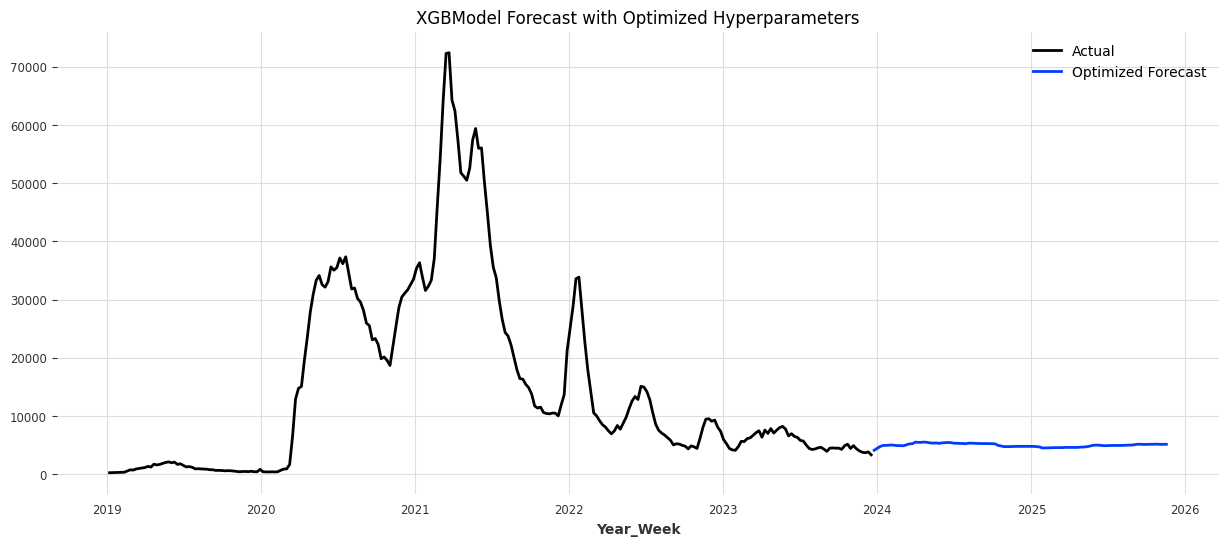

In [25]:
# Visualization
plt.figure(figsize=(15, 6))
train_83.plot(label="Actual")
forecast.plot(label="Optimized Forecast")
plt.title("XGBModel Forecast with Optimized Hyperparameters")
plt.legend()
plt.show()

<Axes: xlabel='Year_Week'>

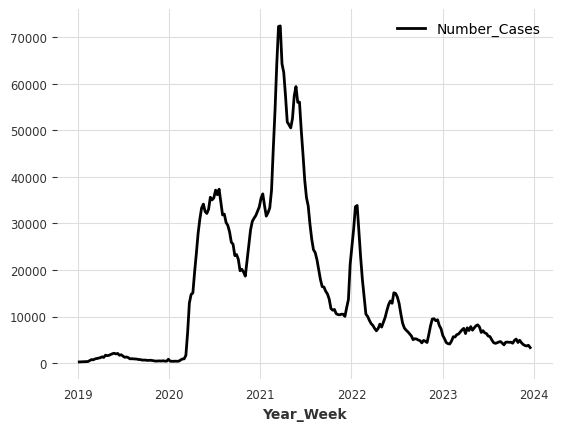

In [26]:
train_83.plot()